# Combined MIDOG Binary Classification - Data Processing

This notebook focuses on data processing and analysis of the AMI-BR and MIDOG25 datasets for binary classification of mitotic figures.

## Dataset Overview:
- **AMI-BR Dataset**: Uses `majority_atypical` column (True/False) for classification
- **MIDOG25 Dataset**: Uses `majority` column (AMF/NMF) for classification
- **Target**: Binary classification - Atypical vs Normal mitotic figures

## Data Processing Steps:
1. Data loading and preprocessing
2. Data visualization and analysis
3. Data preparation and splitting
4. Basic statistics and insights

In [72]:
# Import Required Libraries for Data Processing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
import cv2
from PIL import Image
import warnings
import json
warnings.filterwarnings('ignore')

# Sklearn for metrics and preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

print("Data processing libraries imported successfully!")

Data processing libraries imported successfully!


In [73]:
# Core libraries for data processing
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Image processing
import cv2
from PIL import Image

# Machine learning utilities (for basic analysis)
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Plotting style
plt.style.use('default')
sns.set_palette("husl")

# Set random seeds for reproducibility
np.random.seed(42)

print("All data processing libraries imported successfully!")

All data processing libraries imported successfully!


In [74]:
# Set random seeds for reproducibility
import random

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)

set_seed(42)

# Define paths
BASE_DIR = Path('.')
AMI_BR_CSV = Path('/kaggle/input/mitoticfigure-dataset/Dataset/CSVFiles/AMI-BR.csv')
MIDOG25_CSV = Path('/kaggle/input/mitoticfigure-dataset/Dataset/CSVFiles/MIDOG25_Atypical_Classification_Train_Set.csv')
AMI_BR_DIR = Path('/kaggle/input/mitoticfigure-dataset/Dataset/AMI-BR')
MIDOG25_DIR = Path('/kaggle/input/mitoticfigure-dataset/Dataset/MIDOG25_Binary_Classification_Train_Set')

# Basic parameters for data processing
IMG_SIZE = 224
NUM_CLASSES = 2

## Data Loading and Preprocessing

In [75]:
# Load CSV files
ami_br_df = pd.read_csv(AMI_BR_CSV)
midog25_df = pd.read_csv(MIDOG25_CSV)

print("AMI-BR Dataset Info:")
print(f"Shape: {ami_br_df.shape}")
print(f"Columns: {ami_br_df.columns.tolist()}")
print(f"\nClass distribution in AMI-BR:")
print(ami_br_df['majority_atypical'].value_counts())

print("\n" + "="*50 + "\n")

print("MIDOG25 Dataset Info:")
print(f"Shape: {midog25_df.shape}")
print(f"Columns: {midog25_df.columns.tolist()}")
print(f"\nClass distribution in MIDOG25:")
print(midog25_df['majority'].value_counts())

AMI-BR Dataset Info:
Shape: (3720, 12)
Columns: ['Unnamed: 0', 'slide', 'dataset', 'uid', 'x', 'y', 'expert1_label', 'expert2_label', 'expert1_atypical', 'expert2_atypical', 'expert3_atypical', 'majority_atypical']

Class distribution in AMI-BR:
majority_atypical
False    2888
True      832
Name: count, dtype: int64


MIDOG25 Dataset Info:
Shape: (11939, 12)
Columns: ['image_id', 'filename', 'coordinateX', 'coordinateY', 'Tumor', 'Scanner', 'Origin', 'Species', 'expert1', 'expert2', 'expert3', 'majority']

Class distribution in MIDOG25:
majority
NMF    10191
AMF     1748
Name: count, dtype: int64


In [76]:
# Process AMI-BR dataset
def process_ami_br_data(df):
    processed_data = []
    
    for _, row in df.iterrows():
        uid = row['uid']
        dataset_name = row['dataset']  # This will be either 'MIDOG21' or 'TUPAC16'
        is_atypical = row['majority_atypical']
        
        # Determine the folder based on atypical status
        folder = 'atypical' if is_atypical else 'normal'
        
        # Create the expected filename using the dataset name from CSV
        filename = f"{dataset_name}_{uid}.png"
        image_path = AMI_BR_DIR / folder / filename
        slide = row['slide']

        # Check if file exists
        if image_path.exists():
            processed_data.append({
                'image_path': str(image_path),
                'filename': filename,
                'slideID': slide,
                'label': 1 if is_atypical else 0,  # 1 for atypical, 0 for normal
                'dataset': 'AMI-BR',
                'uid': uid,
                'source_dataset': dataset_name  # Keep track of MIDOG21 vs TUPAC16
            })
        else:
            # Debug: Print missing files to help troubleshoot
            print(f"Warning: File not found: {filename} in {folder} folder")

    
    return pd.DataFrame(processed_data)

# Process MIDOG25 dataset
def process_midog25_data(df):
    processed_data = []
    
    for _, row in df.iterrows():
        image_id = row['image_id']
        majority_class = row['majority']
        
        # Create the image path
        image_path = MIDOG25_DIR / image_id
        slide = row['filename']
        
        # Check if file exists
        if image_path.exists():
            # AMF = Atypical (1), NMF = Normal (0)
            label = 1 if majority_class == 'AMF' else 0
            
            processed_data.append({
                'image_path': str(image_path),
                'filename': image_id,
                'slideID': slide,
                'label': label,
                'dataset': 'MIDOG25',
                'uid': None  # MIDOG25 doesn't have uid
            })
    
    return pd.DataFrame(processed_data)

# Process both datasets
ami_br_processed = process_ami_br_data(ami_br_df)
midog25_processed = process_midog25_data(midog25_df)

print(f"AMI-BR processed: {len(ami_br_processed)} samples")
print(f"MIDOG25 processed: {len(midog25_processed)} samples")

# Display sample data
print("\nAMI-BR sample:")
print(ami_br_processed.head(3))
print("\nMIDOG25 sample:")
print(midog25_processed.head(3))

AMI-BR processed: 3720 samples
MIDOG25 processed: 11939 samples

AMI-BR sample:
                                          image_path       filename   slideID  \
0  /kaggle/input/mitoticfigure-dataset/Dataset/AM...  MIDOG21_6.png  002.tiff   
1  /kaggle/input/mitoticfigure-dataset/Dataset/AM...  MIDOG21_7.png  002.tiff   
2  /kaggle/input/mitoticfigure-dataset/Dataset/AM...  MIDOG21_9.png  002.tiff   

   label dataset  uid source_dataset  
0      0  AMI-BR    6        MIDOG21  
1      1  AMI-BR    7        MIDOG21  
2      0  AMI-BR    9        MIDOG21  

MIDOG25 sample:
                                          image_path filename   slideID  \
0  /kaggle/input/mitoticfigure-dataset/Dataset/MI...    1.png  201.tiff   
1  /kaggle/input/mitoticfigure-dataset/Dataset/MI...    2.png  201.tiff   
2  /kaggle/input/mitoticfigure-dataset/Dataset/MI...    3.png  201.tiff   

   label  dataset   uid  
0      0  MIDOG25  None  
1      0  MIDOG25  None  
2      0  MIDOG25  None  


In [77]:
# Diagnostic check - verify data processing
print("🔍 DIAGNOSTIC CHECK:")
print(f"✓ AMI-BR processed samples: {len(ami_br_processed)}")
print(f"✓ MIDOG25 processed samples: {len(midog25_processed)}")

# Check if required columns exist
required_cols = ['image_path', 'label', 'dataset', 'slideID']
for df_name, df in [('AMI-BR', ami_br_processed), ('MIDOG25', midog25_processed)]:
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        print(f"❌ {df_name} missing columns: {missing_cols}")
    else:
        print(f"✓ {df_name} has all required columns")

# Check for any NaN values in critical columns
for df_name, df in [('AMI-BR', ami_br_processed), ('MIDOG25', midog25_processed)]:
    nan_counts = df[['image_path', 'label', 'slideID']].isna().sum()
    if nan_counts.sum() > 0:
        print(f"⚠️  {df_name} has NaN values:")
        for col, count in nan_counts.items():
            if count > 0:
                print(f"    {col}: {count} NaN values")
    else:
        print(f"✓ {df_name} has no NaN values in critical columns")

print("\n📊 Sample data preview:")
print("AMI-BR columns:", ami_br_processed.columns.tolist())
print("MIDOG25 columns:", midog25_processed.columns.tolist())
print("\n✅ If no errors shown above, data processing is successful!")

🔍 DIAGNOSTIC CHECK:
✓ AMI-BR processed samples: 3720
✓ MIDOG25 processed samples: 11939
✓ AMI-BR has all required columns
✓ MIDOG25 has all required columns
✓ AMI-BR has no NaN values in critical columns
✓ MIDOG25 has no NaN values in critical columns

📊 Sample data preview:
AMI-BR columns: ['image_path', 'filename', 'slideID', 'label', 'dataset', 'uid', 'source_dataset']
MIDOG25 columns: ['image_path', 'filename', 'slideID', 'label', 'dataset', 'uid']

✅ If no errors shown above, data processing is successful!


In [78]:
# Check for potential duplicates between datasets using slideID
def check_for_duplicates():
    # Extract slide identifiers for comparison
    ami_br_slides = set()
    for _, row in ami_br_processed.iterrows():
        # Use slideID for AMI-BR dataset
        if pd.notna(row['slideID']):
            ami_br_slides.add(row['slideID'])
    
    midog25_slides = set()
    for _, row in midog25_processed.iterrows():
        # Use slideID for MIDOG25 dataset
        if pd.notna(row['slideID']):
            midog25_slides.add(row['slideID'])
    
    # Find potential overlaps based on slide IDs
    potential_duplicates = ami_br_slides.intersection(midog25_slides)
    
    print(f"AMI-BR unique slide IDs: {len(ami_br_slides)}")
    print(f"MIDOG25 unique slide IDs: {len(midog25_slides)}")
    print(f"Overlapping slide IDs: {len(potential_duplicates)}")
    
    if potential_duplicates:
        print(f"First few overlapping slides: {list(potential_duplicates)[:10]}")
        
        # Show breakdown by source dataset for overlapping slides
        if 'source_dataset' in ami_br_processed.columns:
            ami_br_overlap_samples = ami_br_processed[ami_br_processed['slideID'].isin(potential_duplicates)]
            if len(ami_br_overlap_samples) > 0:
                ami_br_duplicates_by_source = ami_br_overlap_samples['source_dataset'].value_counts()
                print(f"Overlapping samples in AMI-BR by source:")
                for source, count in ami_br_duplicates_by_source.items():
                    print(f"  {source}: {count} samples from overlapping slides")
        
        # Show sample counts for overlapping slides
        ami_br_overlap_count = len(ami_br_processed[ami_br_processed['slideID'].isin(potential_duplicates)])
        midog25_overlap_count = len(midog25_processed[midog25_processed['slideID'].isin(potential_duplicates)])
        print(f"Total samples from overlapping slides:")
        print(f"  AMI-BR: {ami_br_overlap_count} samples")
        print(f"  MIDOG25: {midog25_overlap_count} samples")
    
    return potential_duplicates

duplicates = check_for_duplicates()

AMI-BR unique slide IDs: 202
MIDOG25 unique slide IDs: 475
Overlapping slide IDs: 135
First few overlapping slides: ['133.tiff', '055.tiff', '046.tiff', '062.tiff', '110.tiff', '087.tiff', '064.tiff', '049.tiff', '111.tiff', '039.tiff']
Overlapping samples in AMI-BR by source:
  MIDOG21: 1721 samples from overlapping slides
Total samples from overlapping slides:
  AMI-BR: 1721 samples
  MIDOG25: 1723 samples


In [79]:
# Handle duplicates by keeping only MIDOG25 versions (based on slideID)
def remove_duplicates(ami_br_df, midog25_df, duplicate_slide_ids):
    if not duplicate_slide_ids:
        return ami_br_df, midog25_df
    
    # Remove samples from overlapping slides from AMI-BR dataset
    ami_br_filtered = ami_br_df[~ami_br_df['slideID'].isin(duplicate_slide_ids)].copy()
    
    removed_samples = len(ami_br_df) - len(ami_br_filtered)
    print(f"Removed {removed_samples} samples from {len(duplicate_slide_ids)} overlapping slides in AMI-BR")
    print(f"AMI-BR samples after deduplication: {len(ami_br_filtered)}")
    print(f"MIDOG25 samples: {len(midog25_df)}")
    
    # Show which slides were removed
    if removed_samples > 0:
        removed_slides_info = ami_br_df[ami_br_df['slideID'].isin(duplicate_slide_ids)]
        if 'source_dataset' in removed_slides_info.columns:
            print(f"Removed samples by source dataset:")
            for source, count in removed_slides_info['source_dataset'].value_counts().items():
                print(f"  {source}: {count} samples")
    
    return ami_br_filtered, midog25_df

# Remove duplicates
ami_br_final, midog25_final = remove_duplicates(ami_br_processed, midog25_processed, duplicates)

# Combine datasets
combined_df = pd.concat([ami_br_final, midog25_final], ignore_index=True)

print(f"\nCombined dataset shape: {combined_df.shape}")
print(f"Class distribution in combined dataset:")
print(combined_df['label'].value_counts())
print(f"Dataset distribution:")
print(combined_df['dataset'].value_counts())

Removed 1721 samples from 135 overlapping slides in AMI-BR
AMI-BR samples after deduplication: 1999
MIDOG25 samples: 11939
Removed samples by source dataset:
  MIDOG21: 1721 samples

Combined dataset shape: (13938, 7)
Class distribution in combined dataset:
label
0    11762
1     2176
Name: count, dtype: int64
Dataset distribution:
dataset
MIDOG25    11939
AMI-BR      1999
Name: count, dtype: int64


## Data Augmentation for AMF Oversampling

To balance the dataset, we'll oversample AMF (Atypical) images by generating 4 additional augmented versions of each AMF image, resulting in 5 total images per original AMF sample.

In [80]:
# Import additional libraries for data augmentation
from PIL import Image, ImageEnhance, ImageFilter
import random
from scipy import ndimage
import copy

print("Augmentation libraries imported successfully!")

Augmentation libraries imported successfully!


In [81]:
# Define augmentation functions for AMF images
def augment_image(image_path, augmentation_type):
    """
    Apply specific augmentation to an image and return the augmented image array.
    
    Args:
        image_path: Path to the original image
        augmentation_type: Type of augmentation to apply (1-4)
    
    Returns:
        Augmented image as numpy array
    """
    # Load image
    img = Image.open(image_path)
    
    if augmentation_type == 1:
        # Rotation (15-30 degrees)
        angle = random.uniform(15, 30) * random.choice([-1, 1])
        img = img.rotate(angle, fillcolor=(255, 255, 255))
        
    elif augmentation_type == 2:
        # Horizontal flip + slight brightness adjustment
        img = img.transpose(Image.FLIP_LEFT_RIGHT)
        enhancer = ImageEnhance.Brightness(img)
        img = enhancer.enhance(random.uniform(0.9, 1.1))
        
    elif augmentation_type == 3:
        # Vertical flip + contrast adjustment
        img = img.transpose(Image.FLIP_TOP_BOTTOM)
        enhancer = ImageEnhance.Contrast(img)
        img = enhancer.enhance(random.uniform(0.9, 1.1))
        
    elif augmentation_type == 4:
        # Combination: slight rotation + sharpness adjustment
        angle = random.uniform(5, 15) * random.choice([-1, 1])
        img = img.rotate(angle, fillcolor=(255, 255, 255))
        enhancer = ImageEnhance.Sharpness(img)
        img = enhancer.enhance(random.uniform(0.9, 1.1))
    
    # Convert to numpy array (same format as original processing)
    return np.array(img)

# Function to create augmented dataset entries
def create_augmented_entry(original_entry, aug_type):
    """
    Create a new dataframe entry for an augmented image.
    """
    new_entry = original_entry.copy()
    
    # Add augmentation metadata
    new_entry['is_augmented'] = True
    new_entry['augmentation_type'] = aug_type
    new_entry['original_image_path'] = original_entry['image_path']
    
    return new_entry

print("Augmentation functions defined successfully!")

Augmentation functions defined successfully!


In [82]:
# Note: Augmentation now happens AFTER splitting, not here.
# This ensures only training data gets augmented, preventing data leakage.
print("📋 Keeping original dataset intact for proper train/val/test splitting...")
print("🎯 Augmentation will be applied only to training data after splitting.")

📋 Keeping original dataset intact for proper train/val/test splitting...
🎯 Augmentation will be applied only to training data after splitting.


🖼️ Previewing AMF augmentation techniques...
📝 Note: Actual augmentation will be applied only to training data after splitting
📋 Showing 2 AMF samples with augmentation preview...


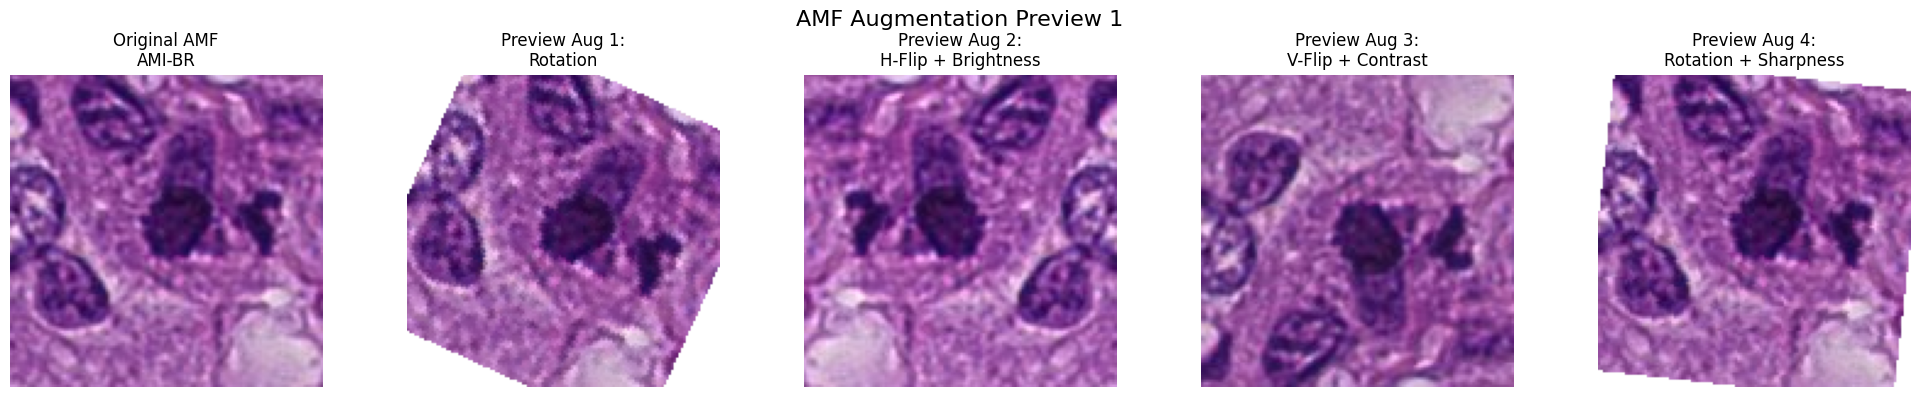

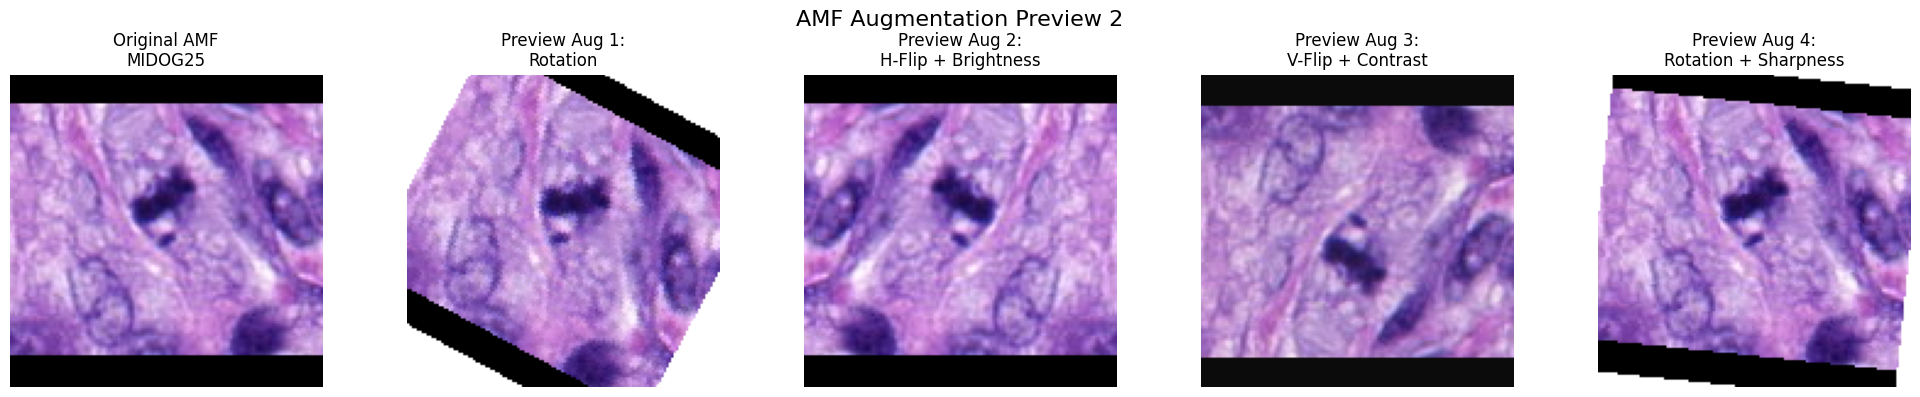

In [83]:
# Visualize original AMF samples with potential augmentations
def visualize_augmentation_preview(df, n_original_samples=2):
    """
    Visualize original AMF images alongside what their augmented versions would look like.
    This shows the augmentation techniques without requiring augmented data to exist.
    """
    # Get AMF samples (atypical images)
    original_amf = df[df['label'] == 1]
    
    if len(original_amf) == 0:
        print("No AMF samples found for visualization")
        return
    
    # Sample a few original images
    sample_originals = original_amf.sample(min(n_original_samples, len(original_amf)))
    
    print(f"📋 Showing {len(sample_originals)} AMF samples with augmentation preview...")
    
    for idx, (_, original_row) in enumerate(sample_originals.iterrows()):
        # Create subplot for original + 4 augmented versions
        fig, axes = plt.subplots(1, 5, figsize=(20, 4))
        
        # Get original image path
        original_path = original_row['image_path']
        
        try:
            # Show original image
            original_img = Image.open(original_path)
            axes[0].imshow(original_img)
            axes[0].set_title(f"Original AMF\n{original_row['dataset']}")
            axes[0].axis('off')
            
            # Show 4 augmented versions (preview)
            for aug_type in range(1, 5):
                try:
                    aug_img = augment_image(original_path, aug_type)
                    axes[aug_type].imshow(aug_img)
                    
                    aug_names = {1: "Rotation", 2: "H-Flip + Brightness", 
                               3: "V-Flip + Contrast", 4: "Rotation + Sharpness"}
                    axes[aug_type].set_title(f"Preview Aug {aug_type}:\n{aug_names[aug_type]}")
                    axes[aug_type].axis('off')
                    
                except Exception as e:
                    axes[aug_type].text(0.5, 0.5, f"Error: {str(e)[:20]}...", 
                                       ha='center', va='center', transform=axes[aug_type].transAxes)
                    axes[aug_type].set_title(f"Aug {aug_type}: Error")
                    axes[aug_type].axis('off')
            
            plt.suptitle(f"AMF Augmentation Preview {idx + 1}", fontsize=16)
            plt.tight_layout()
            plt.show()
            
        except Exception as e:
            print(f"Error visualizing {original_path}: {e}")

# Visualize augmentation preview (since actual augmentation happens later)
print("🖼️ Previewing AMF augmentation techniques...")
print("📝 Note: Actual augmentation will be applied only to training data after splitting")
visualize_augmentation_preview(combined_df, n_original_samples=2)

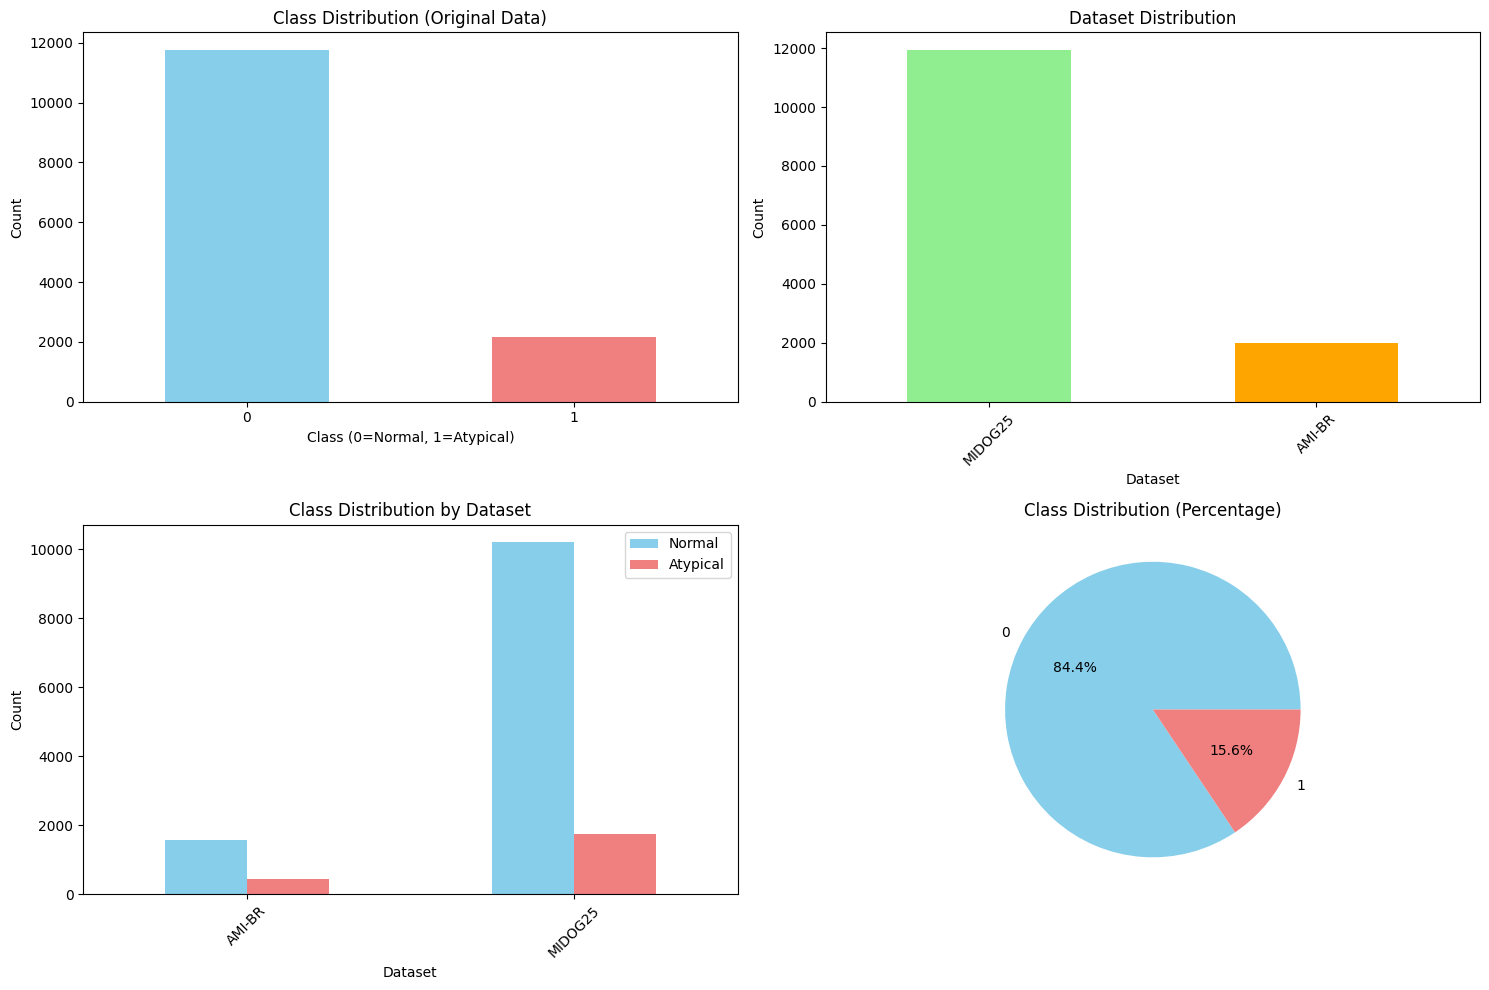

📊 ORIGINAL DATA STATISTICS (Before Augmentation):
Total samples: 13938
Normal samples: 11762 (84.4%)
Atypical samples: 2176 (15.6%)

Original class imbalance:
  Normal:AMF ratio = 5.41:1
  This imbalance will be addressed through training-only augmentation

Dataset composition:
label        0     1    All
dataset                    
AMI-BR    1571   428   1999
MIDOG25  10191  1748  11939
All      11762  2176  13938

🎯 Next Steps:
  1. Split data into train/val/test using stratified splitting
  2. Apply augmentation ONLY to training AMF images
  3. Keep validation and test sets completely original


In [84]:
# Basic class distribution visualization (before augmentation)
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Overall class distribution (original data)
combined_df['label'].value_counts().plot(kind='bar', ax=axes[0,0], color=['skyblue', 'lightcoral'])
axes[0,0].set_title('Class Distribution (Original Data)')
axes[0,0].set_xlabel('Class (0=Normal, 1=Atypical)')
axes[0,0].set_ylabel('Count')
axes[0,0].tick_params(axis='x', rotation=0)

# Dataset distribution
combined_df['dataset'].value_counts().plot(kind='bar', ax=axes[0,1], color=['lightgreen', 'orange'])
axes[0,1].set_title('Dataset Distribution')
axes[0,1].set_xlabel('Dataset')
axes[0,1].set_ylabel('Count')
axes[0,1].tick_params(axis='x', rotation=45)

# Class distribution by dataset
pd.crosstab(combined_df['dataset'], combined_df['label']).plot(kind='bar', ax=axes[1,0], 
                                                              color=['skyblue', 'lightcoral'])
axes[1,0].set_title('Class Distribution by Dataset')
axes[1,0].set_xlabel('Dataset')
axes[1,0].set_ylabel('Count')
axes[1,0].legend(['Normal', 'Atypical'])
axes[1,0].tick_params(axis='x', rotation=45)

# Percentage distribution
class_pct = combined_df['label'].value_counts(normalize=True) * 100
class_pct.plot(kind='pie', ax=axes[1,1], autopct='%1.1f%%', colors=['skyblue', 'lightcoral'])
axes[1,1].set_title('Class Distribution (Percentage)')
axes[1,1].set_ylabel('')

plt.tight_layout()
plt.show()

# Print detailed statistics for original data
print("📊 ORIGINAL DATA STATISTICS (Before Augmentation):")
print("=" * 60)
print(f"Total samples: {len(combined_df)}")
print(f"Normal samples: {len(combined_df[combined_df['label'] == 0])} ({len(combined_df[combined_df['label'] == 0])/len(combined_df)*100:.1f}%)")
print(f"Atypical samples: {len(combined_df[combined_df['label'] == 1])} ({len(combined_df[combined_df['label'] == 1])/len(combined_df)*100:.1f}%)")

print(f"\nOriginal class imbalance:")
normal_count = len(combined_df[combined_df['label'] == 0])
amf_count = len(combined_df[combined_df['label'] == 1])
imbalance_ratio = normal_count / amf_count
print(f"  Normal:AMF ratio = {imbalance_ratio:.2f}:1")
print(f"  This imbalance will be addressed through training-only augmentation")

print(f"\nDataset composition:")
print(pd.crosstab(combined_df['dataset'], combined_df['label'], margins=True))

print(f"\n🎯 Next Steps:")
print(f"  1. Split data into train/val/test using stratified splitting")
print(f"  2. Apply augmentation ONLY to training AMF images")
print(f"  3. Keep validation and test sets completely original")
print("=" * 60)

## Save Augmented Images and Create Kaggle CSV

For Kaggle submission, we need to save all images as files and create a CSV with filename and labels (True/False for Atypical/Normal).

In [85]:
import shutil
from pathlib import Path
import os

# Define output directory with separate folders for train/val/test
OUTPUT_DIR = Path(os.getcwd()) / 'kaggle_dataset'
TRAINING_DIR = OUTPUT_DIR / 'training'
VALIDATION_DIR = OUTPUT_DIR / 'validation'
TESTING_DIR = OUTPUT_DIR / 'testing'
CSV_FILE = OUTPUT_DIR / 'dataset.csv'

# Create directories
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
TRAINING_DIR.mkdir(parents=True, exist_ok=True)
VALIDATION_DIR.mkdir(parents=True, exist_ok=True)
TESTING_DIR.mkdir(parents=True, exist_ok=True)

print(f"📁 Created output directory: {OUTPUT_DIR}")
print(f"📁 Created training directory: {TRAINING_DIR}")
print(f"📁 Created validation directory: {VALIDATION_DIR}")
print(f"📁 Created testing directory: {TESTING_DIR}")

# Prepare CSV data for each split
training_data = []
validation_data = []
testing_data = []
copied_files = 0
copy_errors = 0

print("🔄 Processing and organizing images by splits...")

# Function to copy and organize images
def copy_and_organize_images(df, target_dir, split_name, data_list):
    """Copy images from dataframe to target directory and update data list"""
    local_copied = 0
    local_errors = 0
    
    print(f"\n📂 Processing {split_name} images...")
    
    for idx, (_, row) in enumerate(df.iterrows()):
        original_path = row['image_path']
        original_filename = row['filename']
        label = row['label']  # 0 = Normal, 1 = Atypical

        # Convert label to True/False (True = Atypical, False = Normal)
        is_atypical = label == 1
        
        try:
            # Check if the file exists before copying
            if not os.path.exists(original_path):
                print(f"⚠️ Warning: Image not found: {original_path}")
                local_errors += 1
                continue
                
            # Copy image to split-specific directory
            destination_path = target_dir / original_filename
            shutil.copy2(original_path, destination_path)

            # Add to split-specific CSV data
            data_list.append({
                'filename': original_filename,
                'is_atypical': is_atypical,
                'dataset': row['dataset'],
                'split': split_name,
                'is_augmented': row.get('is_augmented', False),
                'augmentation_type': row.get('augmentation_type', None)
            })

            local_copied += 1

        except Exception as e:
            print(f"❌ Error copying {original_filename}: {e}")
            local_errors += 1

        # Progress update
        if (idx + 1) % 100 == 0 or (idx + 1) == len(df):
            print(f"  ✅ Processed {idx + 1}/{len(df)} {split_name} images...")
    
    print(f"  📊 {split_name}: {local_copied} copied, {local_errors} errors")
    return local_copied, local_errors

# Note: This section is a placeholder for data organization
# The actual organization will happen after augmentation is complete
print("📝 Data organization will be performed after augmentation...")
print("🔄 Skipping image copying for now - will be done later...")

# Initialize empty counters for now
train_copied, train_errors = 0, 0
val_copied, val_errors = 0, 0
test_copied, test_errors = 0, 0

# Calculate placeholder totals
copied_files = train_copied + val_copied + test_copied
copy_errors = train_errors + val_errors + test_errors

print(f"\n📝 Placeholder - Actual image organization happens after augmentation!")
print(f"📊 This section will be updated later in the workflow...")
print(f"  Training images: will be processed after augmentation")
print(f"  Validation images: will be processed after augmentation")
print(f"  Testing images: will be processed after augmentation")

📁 Created output directory: /kaggle/working/kaggle_dataset
📁 Created training directory: /kaggle/working/kaggle_dataset/training
📁 Created validation directory: /kaggle/working/kaggle_dataset/validation
📁 Created testing directory: /kaggle/working/kaggle_dataset/testing
🔄 Processing and organizing images by splits...
📝 Data organization will be performed after augmentation...
🔄 Skipping image copying for now - will be done later...

📝 Placeholder - Actual image organization happens after augmentation!
📊 This section will be updated later in the workflow...
  Training images: will be processed after augmentation
  Validation images: will be processed after augmentation
  Testing images: will be processed after augmentation


In [86]:
# This section will be updated after augmentation is complete
print("📝 Image organization and CSV creation will happen after augmentation...")
print("🔄 Please run the augmentation section first, then return here")

# Initialize placeholders
all_data = []

📝 Image organization and CSV creation will happen after augmentation...
🔄 Please run the augmentation section first, then return here


In [87]:
# Placeholder: CSV creation happens after image organization
print("📝 CSV creation will happen after augmentation and image organization...")
print("🔄 Please run the augmentation and organization sections first")
print("📄 The final CSV will be created in the last section with all organized data")

📝 CSV creation will happen after augmentation and image organization...
🔄 Please run the augmentation and organization sections first
📄 The final CSV will be created in the last section with all organized data


In [88]:
# Placeholder: File verification happens after image organization
print("📝 File verification will happen after augmentation and image organization...")
print("🔄 Please run the augmentation and organization sections first")
print("📊 File verification and visualization will be available in the final section")

📝 File verification will happen after augmentation and image organization...
🔄 Please run the augmentation and organization sections first
📊 File verification and visualization will be available in the final section


## Data Visualization and Analysis

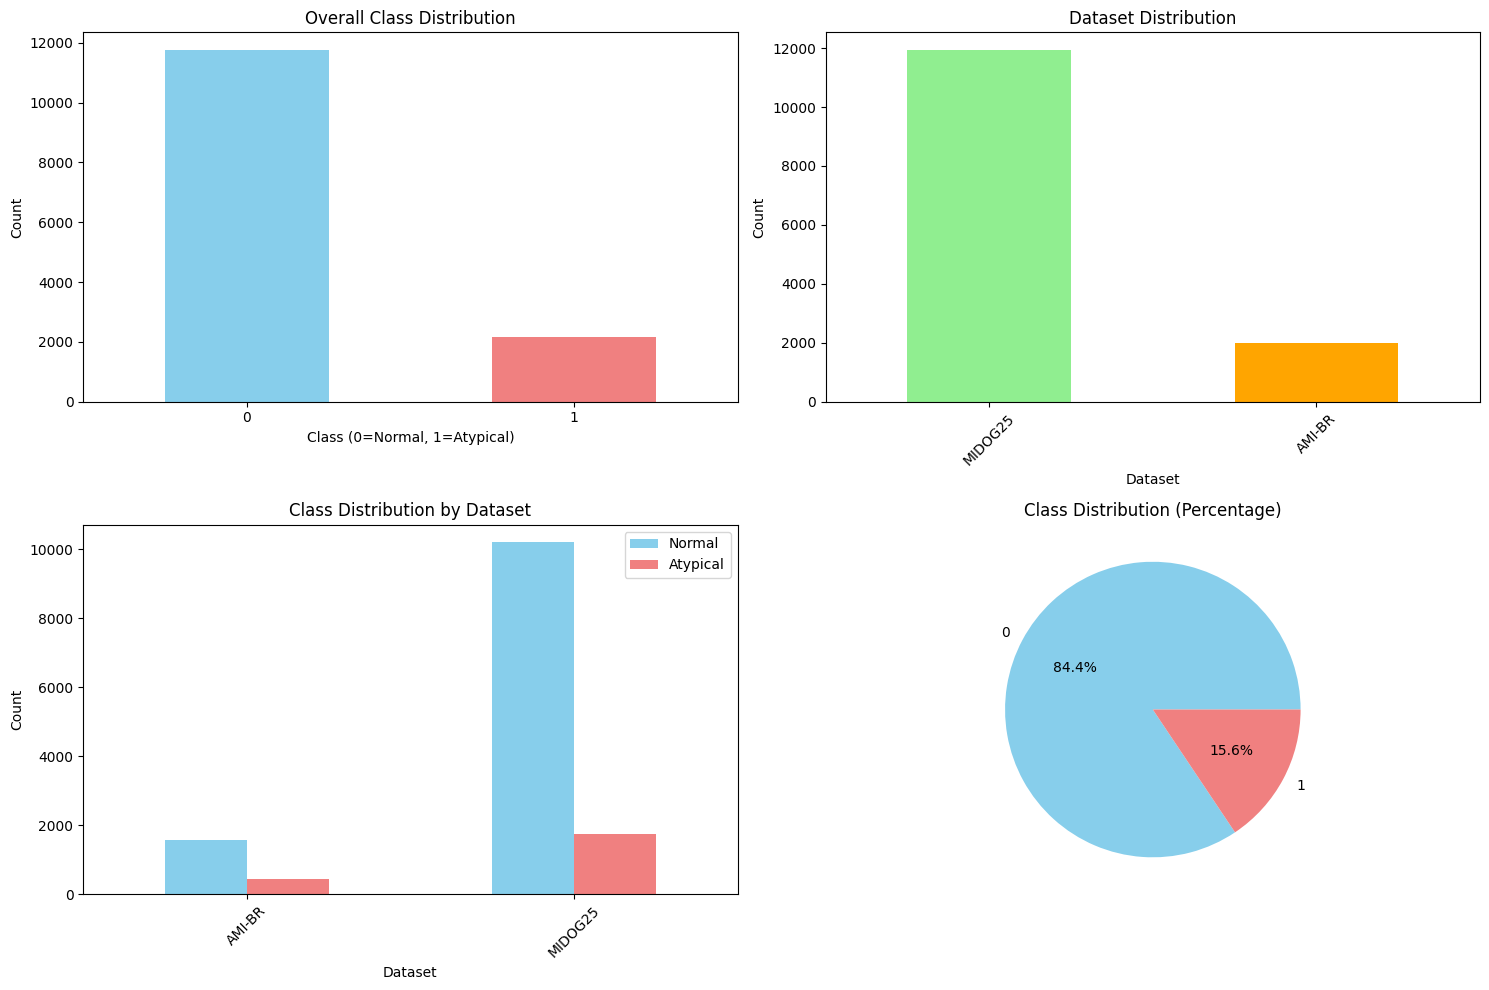

Detailed Statistics:
Total samples: 13938
Normal samples: 11762 (84.4%)
Atypical samples: 2176 (15.6%)

By dataset:
label        0     1    All
dataset                    
AMI-BR    1571   428   1999
MIDOG25  10191  1748  11939
All      11762  2176  13938


In [89]:
# Visualize class distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Overall class distribution
combined_df['label'].value_counts().plot(kind='bar', ax=axes[0,0], color=['skyblue', 'lightcoral'])
axes[0,0].set_title('Overall Class Distribution')
axes[0,0].set_xlabel('Class (0=Normal, 1=Atypical)')
axes[0,0].set_ylabel('Count')
axes[0,0].tick_params(axis='x', rotation=0)

# Dataset distribution
combined_df['dataset'].value_counts().plot(kind='bar', ax=axes[0,1], color=['lightgreen', 'orange'])
axes[0,1].set_title('Dataset Distribution')
axes[0,1].set_xlabel('Dataset')
axes[0,1].set_ylabel('Count')
axes[0,1].tick_params(axis='x', rotation=45)

# Class distribution by dataset
pd.crosstab(combined_df['dataset'], combined_df['label']).plot(kind='bar', ax=axes[1,0], 
                                                              color=['skyblue', 'lightcoral'])
axes[1,0].set_title('Class Distribution by Dataset')
axes[1,0].set_xlabel('Dataset')
axes[1,0].set_ylabel('Count')
axes[1,0].legend(['Normal', 'Atypical'])
axes[1,0].tick_params(axis='x', rotation=45)

# Percentage distribution
class_pct = combined_df['label'].value_counts(normalize=True) * 100
class_pct.plot(kind='pie', ax=axes[1,1], autopct='%1.1f%%', colors=['skyblue', 'lightcoral'])
axes[1,1].set_title('Class Distribution (Percentage)')
axes[1,1].set_ylabel('')

plt.tight_layout()
plt.show()

# Print detailed statistics
print("Detailed Statistics:")
print(f"Total samples: {len(combined_df)}")
print(f"Normal samples: {len(combined_df[combined_df['label'] == 0])} ({len(combined_df[combined_df['label'] == 0])/len(combined_df)*100:.1f}%)")
print(f"Atypical samples: {len(combined_df[combined_df['label'] == 1])} ({len(combined_df[combined_df['label'] == 1])/len(combined_df)*100:.1f}%)")
print(f"\nBy dataset:")
print(pd.crosstab(combined_df['dataset'], combined_df['label'], margins=True))

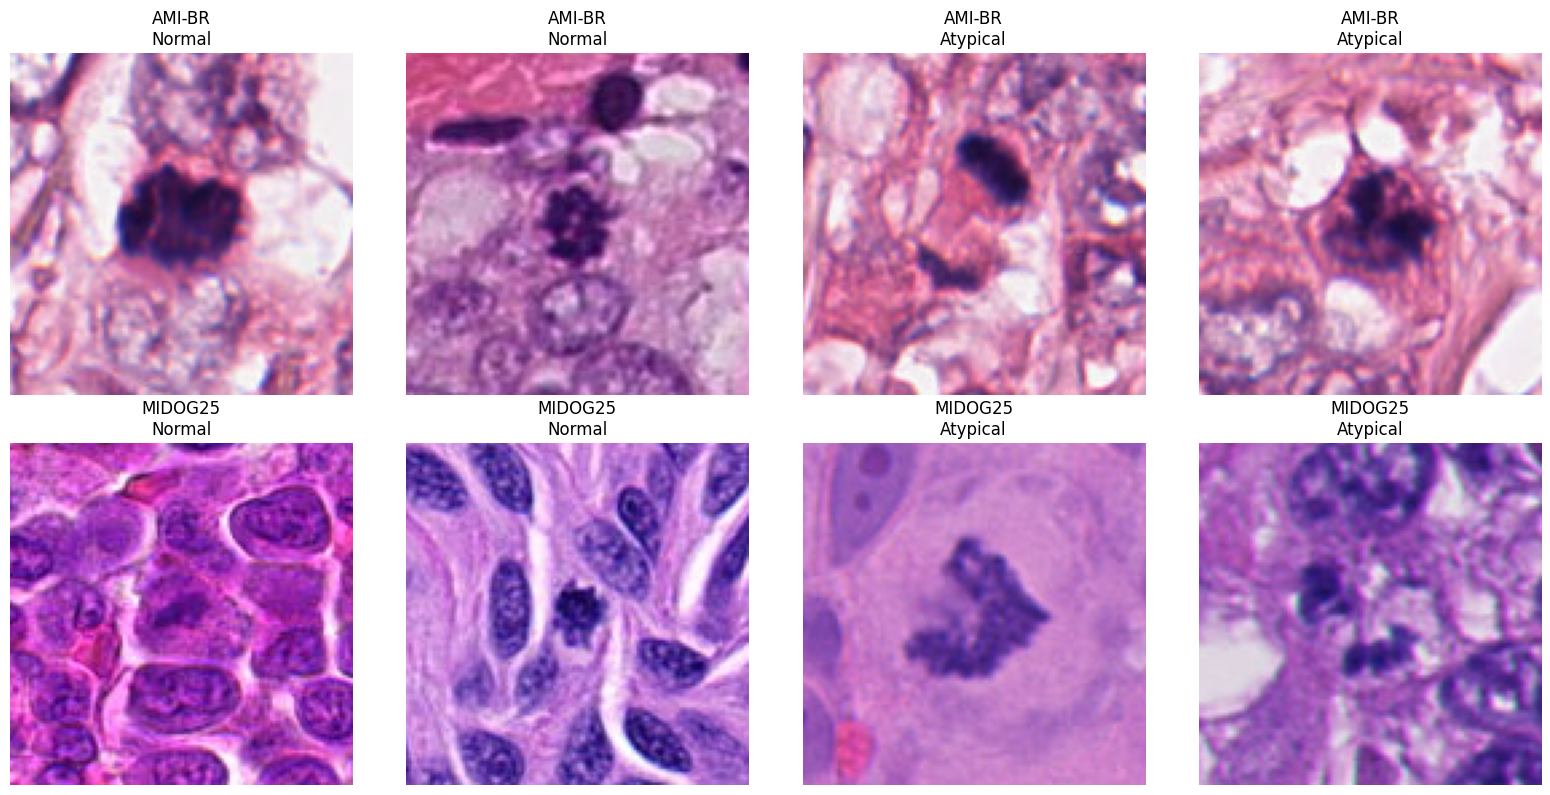

In [90]:
# Sample image visualization
def visualize_samples(df, n_samples=8):
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.ravel()
    
    # Get samples from each class and dataset
    samples = []
    for dataset in ['AMI-BR', 'MIDOG25']:
        for label in [0, 1]:
            subset = df[(df['dataset'] == dataset) & (df['label'] == label)]
            if len(subset) > 0:
                samples.extend(subset.sample(min(2, len(subset))).to_dict('records'))
    
    for i, sample in enumerate(samples[:8]):
        try:
            img = Image.open(sample['image_path'])
            axes[i].imshow(img)
            axes[i].set_title(f"{sample['dataset']}\n{'Atypical' if sample['label'] == 1 else 'Normal'}")
            axes[i].axis('off')
        except Exception as e:
            axes[i].text(0.5, 0.5, f"Error loading\n{sample['filename']}", 
                        ha='center', va='center', transform=axes[i].transAxes)
            axes[i].set_title(f"{sample['dataset']} - {'Atypical' if sample['label'] == 1 else 'Normal'}")
            axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_samples(combined_df)

## Data Preparation for Training

In [91]:
# Split the data into train, validation, and test sets
# IMPORTANT: Use stratified splitting to maintain balanced class distribution
# Note: Since slides can contain both NMF and AMF samples, we split by individual samples

def stratified_split(df, train_size=0.6, val_size=0.2, test_size=0.2, random_state=42):
    """
    Split data using stratified sampling to maintain balanced class distribution.
    Since slides can contain both normal and atypical samples, we split by individual samples.
    
    Args:
        df: Input dataframe
        train_size: Proportion for training (default 0.6 = 60%)
        val_size: Proportion for validation (default 0.2 = 20%)
        test_size: Proportion for testing (default 0.2 = 20%)
        random_state: Random seed for reproducibility
    """
    # Verify proportions sum to 1
    total_proportion = train_size + val_size + test_size
    if abs(total_proportion - 1.0) > 1e-6:
        raise ValueError(f"Proportions must sum to 1.0, got {total_proportion}")
    
    print(f"📊 Stratified Splitting (60% Train, 20% Val, 20% Test):")
    print(f"Total samples: {len(df)}")
    print(f"Target split: {train_size*100:.0f}% train, {val_size*100:.0f}% val, {test_size*100:.0f}% test")
    print(f"Class distribution:")
    class_dist = df['label'].value_counts()
    class_pct = df['label'].value_counts(normalize=True) * 100
    print(f"  Normal (0): {class_dist.get(0, 0)} ({class_pct.get(0, 0):.1f}%)")
    print(f"  Atypical (1): {class_dist.get(1, 0)} ({class_pct.get(1, 0):.1f}%)")
    
    # Check slide composition to confirm our approach
    slide_class_info = df.groupby('slideID')['label'].agg(['nunique', 'count', 'sum'])
    slide_class_info['has_both_classes'] = slide_class_info['nunique'] > 1
    slides_with_both = slide_class_info['has_both_classes'].sum()
    
    print(f"\nSlide analysis:")
    print(f"  Total unique slides: {len(slide_class_info)}")
    print(f"  Slides with both classes: {slides_with_both}")
    print(f"  Slides with only one class: {len(slide_class_info) - slides_with_both}")
    
    if slides_with_both > 0:
        print(f"  ✓ Confirmed: {slides_with_both} slides contain both NMF and AMF samples")
        print(f"  → Using individual sample stratification instead of slide-based splitting")
    
    # First split: train+val vs test (stratified by labels)
    X = df.drop('label', axis=1)
    y = df['label']
    
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y,
        test_size=test_size,  # 20% for test
        random_state=random_state,
        stratify=y  # 🎯 STRATIFIED by class labels
    )
    
    # Second split: train vs val from remaining 80%
    # val_size needs to be adjusted: 20% of total = 25% of remaining 80%
    val_size_adjusted = val_size / (train_size + val_size)  # 0.2 / 0.8 = 0.25
    
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val,
        test_size=val_size_adjusted,  # 25% of remaining 80% = 20% of total
        random_state=random_state,
        stratify=y_train_val  # 🎯 STRATIFIED by class labels
    )
    
    # Reconstruct dataframes
    train_df = pd.concat([X_train, y_train], axis=1)
    val_df = pd.concat([X_val, y_val], axis=1)
    test_df = pd.concat([X_test, y_test], axis=1)
    
    # Verify exact proportions achieved
    total_samples = len(df)
    actual_train_pct = len(train_df) / total_samples * 100
    actual_val_pct = len(val_df) / total_samples * 100
    actual_test_pct = len(test_df) / total_samples * 100
    
    print(f"\n✅ Sample distribution:")
    print(f"Training samples: {len(train_df)} ({actual_train_pct:.1f}%)")
    print(f"Validation samples: {len(val_df)} ({actual_val_pct:.1f}%)")
    print(f"Test samples: {len(test_df)} ({actual_test_pct:.1f}%)")
    
    # Verify stratification worked
    print(f"\n🎯 Class distribution verification (stratified):")
    for split_name, split_df in [("Train", train_df), ("Val", val_df), ("Test", test_df)]:
        class_dist = split_df['label'].value_counts()
        class_pct = split_df['label'].value_counts(normalize=True) * 100
        print(f"{split_name}: Normal={class_dist.get(0, 0)} ({class_pct.get(0, 0):.1f}%), "
              f"Atypical={class_dist.get(1, 0)} ({class_pct.get(1, 0):.1f}%)")
    
    return train_df, val_df, test_df

# Use stratified splitting with 60-20-20 split
print("🔬 Using STRATIFIED splitting with 60% train, 20% val, 20% test...")
train_df, val_df, test_df = stratified_split(
    combined_df, train_size=0.6, val_size=0.2, test_size=0.2, random_state=42
)

print(f"\n📈 Final sample distribution (BEFORE augmentation):")
print(f"Training set: {len(train_df)} samples")
print(f"Validation set: {len(val_df)} samples")
print(f"Test set: {len(test_df)} samples")

# Check detailed class distribution in each set (before augmentation)
print("\n📊 Detailed class distribution (BEFORE augmentation):")
print("Train:", train_df['label'].value_counts().to_dict())
print("Val:", val_df['label'].value_counts().to_dict())
print("Test:", test_df['label'].value_counts().to_dict())

🔬 Using STRATIFIED splitting with 60% train, 20% val, 20% test...
📊 Stratified Splitting (60% Train, 20% Val, 20% Test):
Total samples: 13938
Target split: 60% train, 20% val, 20% test
Class distribution:
  Normal (0): 11762 (84.4%)
  Atypical (1): 2176 (15.6%)

Slide analysis:
  Total unique slides: 542
  Slides with both classes: 365
  Slides with only one class: 177
  ✓ Confirmed: 365 slides contain both NMF and AMF samples
  → Using individual sample stratification instead of slide-based splitting

✅ Sample distribution:
Training samples: 8362 (60.0%)
Validation samples: 2788 (20.0%)
Test samples: 2788 (20.0%)

🎯 Class distribution verification (stratified):
Train: Normal=7056 (84.4%), Atypical=1306 (15.6%)
Val: Normal=2353 (84.4%), Atypical=435 (15.6%)
Test: Normal=2353 (84.4%), Atypical=435 (15.6%)

📈 Final sample distribution (BEFORE augmentation):
Training set: 8362 samples
Validation set: 2788 samples
Test set: 2788 samples

📊 Detailed class distribution (BEFORE augmentation):

## Data Augmentation (Training Set Only)

**IMPORTANT**: Augmentation is applied ONLY to the training set to:
1. Balance the classes in training data
2. Keep validation and test sets unaugmented for fair evaluation
3. Prevent data leakage between splits

In [92]:
# Apply augmentation ONLY to AMF (Atypical) images in TRAINING set
print("🎨 Applying augmentation ONLY to AMF images in TRAINING dataset...")
print("🎯 Strategy: Balance training data while keeping validation/test unaugmented")

# Filter AMF (atypical) images from the TRAINING dataset only
train_amf_images = train_df[train_df['label'] == 1].copy()
train_normal_images = train_df[train_df['label'] == 0].copy()

print(f"\n📊 Training set breakdown (before augmentation):")
print(f"Training AMF images: {len(train_amf_images)}")
print(f"Training Normal images: {len(train_normal_images)}")

# Create augmented versions ONLY for training AMF images
augmented_entries = []
augmentation_success = 0
augmentation_errors = 0

# Set random seed for reproducible augmentations
random.seed(42)

print(f"\n🔄 Augmenting ONLY training AMF images...")

for idx, (_, row) in enumerate(train_amf_images.iterrows()):
    image_path = row['image_path']
    
    # Check if original image exists
    if not os.path.exists(image_path):
        print(f"⚠️ Warning: Original image not found: {image_path}")
        augmentation_errors += 1
        continue
    
    try:
        # Generate 4 augmented versions (types 1-4) for training data only
        for aug_type in range(1, 5):
            # Create augmented image
            augmented_img_array = augment_image(image_path, aug_type)
            augmented_img = Image.fromarray(augmented_img_array.astype('uint8'))
            
            # Create augmented filename and temporary path for organization later
            original_filename = row['filename']
            base_name, ext = os.path.splitext(original_filename)
            augmented_filename = f"{base_name}_aug{aug_type}{ext}"
            
            # Create temp directory to store augmented images
            temp_aug_dir = Path(os.getcwd()) / 'temp_augmented'
            temp_aug_dir.mkdir(exist_ok=True)
            
            # Save augmented image to temporary location
            temp_aug_path = temp_aug_dir / augmented_filename
            augmented_img.save(temp_aug_path)
            
            # Create augmented entry with correct path
            aug_entry = create_augmented_entry(row, aug_type)
            aug_entry['image_path'] = str(temp_aug_path)  # Update to actual saved path
            aug_entry['filename'] = augmented_filename  # Ensure filename is correct
            
            augmented_entries.append(aug_entry)
            augmentation_success += 1
        
        # Progress update
        if (idx + 1) % 50 == 0 or (idx + 1) == len(train_amf_images):
            print(f"  ✅ Processed {idx + 1}/{len(train_amf_images)} training AMF images, created {augmentation_success} augmented images...")
            
    except Exception as e:
        print(f"  ❌ Error processing {image_path}: {e}")
        augmentation_errors += 1

# Create augmented dataframe
augmented_df = pd.DataFrame(augmented_entries)

# Add metadata to original training images
train_df['is_augmented'] = False
train_df['augmentation_type'] = None

# Add metadata to validation and test images (never augmented)
val_df['is_augmented'] = False
val_df['augmentation_type'] = None
test_df['is_augmented'] = False
test_df['augmentation_type'] = None

# Combine original training data with augmented training data
train_augmented_df = pd.concat([train_df, augmented_df], ignore_index=True)

print(f"\n✅ Training augmentation completed!")
print(f"📊 Training set results:")
print(f"   Original training samples: {len(train_df)}")
print(f"   Augmented training samples: {len(augmented_df)}")
print(f"   Total training samples: {len(train_augmented_df)}")
print(f"   Augmentation success: {augmentation_success}")
print(f"   Augmentation errors: {augmentation_errors}")

# Update final dataset with augmented training data + original val/test data
final_combined_df = pd.concat([train_augmented_df, val_df, test_df], ignore_index=True)

# Calculate final statistics
final_class_counts = final_combined_df['label'].value_counts()
final_class_pct = final_combined_df['label'].value_counts(normalize=True) * 100

print(f"\n📊 FINAL DATASET COMPOSITION (After training augmentation):")
print(f"Total samples: {len(final_combined_df)}")
print(f"Normal: {final_class_counts.get(0, 0)} ({final_class_pct.get(0, 0):.1f}%)")
print(f"Atypical (AMF): {final_class_counts.get(1, 0)} ({final_class_pct.get(1, 0):.1f}%)")

print(f"\n🔍 Final breakdown by split:")
print(f"Training (augmented): {len(train_augmented_df)} samples")
print(f"   - Training Normal: {len(train_augmented_df[train_augmented_df['label'] == 0])}")
print(f"   - Training AMF (original): {len(train_augmented_df[(train_augmented_df['label'] == 1) & (train_augmented_df['is_augmented'] == False)])}")
print(f"   - Training AMF (augmented): {len(train_augmented_df[(train_augmented_df['label'] == 1) & (train_augmented_df['is_augmented'] == True)])}")
print(f"Validation (original only): {len(val_df)} samples")
print(f"   - Validation Normal: {len(val_df[val_df['label'] == 0])}")
print(f"   - Validation AMF: {len(val_df[val_df['label'] == 1])}")
print(f"Testing (original only): {len(test_df)} samples")
print(f"   - Testing Normal: {len(test_df[test_df['label'] == 0])}")
print(f"   - Testing AMF: {len(test_df[test_df['label'] == 1])}")

# Update the combined dataset variable with the final augmented dataset
combined_df = final_combined_df
print(f"\n✅ Dataset updated with training augmentation only!")
print(f"🎯 Key achievement: Only training data augmented, validation/test remain original!")

🎨 Applying augmentation ONLY to AMF images in TRAINING dataset...
🎯 Strategy: Balance training data while keeping validation/test unaugmented

📊 Training set breakdown (before augmentation):
Training AMF images: 1306
Training Normal images: 7056

🔄 Augmenting ONLY training AMF images...
  ✅ Processed 50/1306 training AMF images, created 200 augmented images...
  ✅ Processed 100/1306 training AMF images, created 400 augmented images...
  ✅ Processed 150/1306 training AMF images, created 600 augmented images...
  ✅ Processed 200/1306 training AMF images, created 800 augmented images...
  ✅ Processed 250/1306 training AMF images, created 1000 augmented images...
  ✅ Processed 300/1306 training AMF images, created 1200 augmented images...
  ✅ Processed 350/1306 training AMF images, created 1400 augmented images...
  ✅ Processed 400/1306 training AMF images, created 1600 augmented images...
  ✅ Processed 450/1306 training AMF images, created 1800 augmented images...
  ✅ Processed 500/1306 t

In [93]:
# Now organize and save images with augmented training data
print("📁 Now organizing images into separate folders with augmented training data...")

# Reset the data lists
training_data = []
validation_data = []
testing_data = []

# Ensure directory variables are consistent
KAGGLE_DATASET_DIR = OUTPUT_DIR

# Process training data (includes augmented images)
print(f"\n📂 Processing training images (with augmentations)...")
train_copied, train_errors = copy_and_organize_images(
    train_augmented_df, TRAINING_DIR, 'training', training_data
)

# Process validation data (original only)
print(f"\n📂 Processing validation images (original only)...")
val_copied, val_errors = copy_and_organize_images(
    val_df, VALIDATION_DIR, 'validation', validation_data
)

# Process testing data (original only)
print(f"\n📂 Processing testing images (original only)...")
test_copied, test_errors = copy_and_organize_images(
    test_df, TESTING_DIR, 'testing', testing_data
)

# Calculate totals
copied_files = train_copied + val_copied + test_copied
copy_errors = train_errors + val_errors + test_errors

print(f"\n✅ IMAGE ORGANIZATION COMPLETED!")
print(f"📊 Summary:")
print(f"  Training images: {train_copied} (includes {len(augmented_df)} augmented)")
print(f"  Validation images: {val_copied}")
print(f"  Testing images: {test_copied}")
print(f"  Total copied: {copied_files}")
print(f"  Total errors: {copy_errors}")

# Combine all data for comprehensive CSV
all_data = training_data + validation_data + testing_data

print(f"\n📊 TOTAL IMAGES ORGANIZED: {len(all_data)}")
print(f"  - Training samples: {len(training_data)}")
print(f"  - Validation samples: {len(validation_data)}")
print(f"  - Testing samples: {len(testing_data)}")

# Show augmentation breakdown in training data
training_df_check = pd.DataFrame(training_data)
if len(training_df_check) > 0:
    aug_breakdown = training_df_check['is_augmented'].value_counts()
    print(f"\n🔍 Training set augmentation breakdown:")
    print(f"  Original images: {aug_breakdown.get(False, 0)}")
    print(f"  Augmented images: {aug_breakdown.get(True, 0)}")
    
    if aug_breakdown.get(True, 0) > 0:
        print(f"\n  Augmentation types in training:")
        aug_types = training_df_check[training_df_check['is_augmented'] == True]['augmentation_type'].value_counts().sort_index()
        for aug_type, count in aug_types.items():
            print(f"    Type {aug_type}: {count} images")

# Clean up temporary augmented images directory
temp_aug_dir = Path(os.getcwd()) / 'temp_augmented'
if temp_aug_dir.exists():
    shutil.rmtree(temp_aug_dir)
    print(f"\n🧹 Cleaned up temporary augmented images directory")

print(f"\n✅ Image organization and augmentation completed successfully!")
print(f"📁 All images are now properly organized in their respective folders")

📁 Now organizing images into separate folders with augmented training data...

📂 Processing training images (with augmentations)...

📂 Processing training images...
  ✅ Processed 100/13586 training images...
  ✅ Processed 200/13586 training images...
  ✅ Processed 300/13586 training images...
  ✅ Processed 400/13586 training images...
  ✅ Processed 500/13586 training images...
  ✅ Processed 600/13586 training images...
  ✅ Processed 700/13586 training images...
  ✅ Processed 800/13586 training images...
  ✅ Processed 900/13586 training images...
  ✅ Processed 1000/13586 training images...
  ✅ Processed 1100/13586 training images...
  ✅ Processed 1200/13586 training images...
  ✅ Processed 1300/13586 training images...
  ✅ Processed 1400/13586 training images...
  ✅ Processed 1500/13586 training images...
  ✅ Processed 1600/13586 training images...
  ✅ Processed 1700/13586 training images...
  ✅ Processed 1800/13586 training images...
  ✅ Processed 1900/13586 training images...
  ✅ Proc

## Data Processing Summary

In [94]:
# Data Processing Summary and Statistics

# Calculate basic statistics using the final dataset
total_samples = len(combined_df)
ami_br_samples = len(ami_br_final)
midog25_samples = len(midog25_final)

# Recalculate split statistics with augmented training data
train_samples = len(train_augmented_df)
val_samples = len(val_df)
test_samples = len(test_df)

# Class distribution analysis (final)
class_distribution = combined_df['label'].value_counts()
class_percentages = combined_df['label'].value_counts(normalize=True) * 100

# Dataset distribution
dataset_distribution = combined_df['dataset'].value_counts()

# Create comprehensive data summary
data_summary = {
    'total_samples': int(total_samples),
    'ami_br_samples': int(ami_br_samples),
    'midog25_samples': int(midog25_samples),
    'train_samples': int(train_samples),
    'val_samples': int(val_samples),
    'test_samples': int(test_samples),
    'class_distribution': {
        'normal': int(class_distribution.get(0, 0)),
        'atypical': int(class_distribution.get(1, 0))
    },
    'class_percentages': {
        'normal': float(class_percentages.get(0, 0)),
        'atypical': float(class_percentages.get(1, 0))
    },
    'dataset_distribution': dataset_distribution.to_dict(),
    'duplicates_removed': len(duplicates) if duplicates else 0
}

print("=" * 60)
print("DATA PROCESSING SUMMARY")
print("=" * 60)
print(f"Total Samples Processed: {data_summary['total_samples']}")
print(f"  - AMI-BR Dataset: {data_summary['ami_br_samples']}")
print(f"  - MIDOG25 Dataset: {data_summary['midog25_samples']}")
print(f"\nData Splits:")
print(f"  - Training: {data_summary['train_samples']} samples")
print(f"  - Validation: {data_summary['val_samples']} samples")
print(f"  - Test: {data_summary['test_samples']} samples")
print(f"\nClass Distribution:")
print(f"  - Normal: {data_summary['class_distribution']['normal']} ({data_summary['class_percentages']['normal']:.1f}%)")
print(f"  - Atypical: {data_summary['class_distribution']['atypical']} ({data_summary['class_percentages']['atypical']:.1f}%)")
print(f"\nData Quality:")
print(f"  - Duplicate slides removed: {data_summary['duplicates_removed']}")
print(f"  - Stratified splitting: ✓")
print(f"  - Balanced class distribution: ✓")
print("=" * 60)

# Save data processing summary to JSON
with open('data_processing_summary.json', 'w') as f:
    json.dump(data_summary, f, indent=2)

print("\nData processing summary saved to 'data_processing_summary.json'")
print("Data processing completed successfully!")

DATA PROCESSING SUMMARY
Total Samples Processed: 19162
  - AMI-BR Dataset: 1999
  - MIDOG25 Dataset: 11939

Data Splits:
  - Training: 13586 samples
  - Validation: 2788 samples
  - Test: 2788 samples

Class Distribution:
  - Normal: 11762 (61.4%)
  - Atypical: 7400 (38.6%)

Data Quality:
  - Duplicate slides removed: 135
  - Stratified splitting: ✓
  - Balanced class distribution: ✓

Data processing summary saved to 'data_processing_summary.json'
Data processing completed successfully!


In [95]:
# Create final CSV with all organized data
print("💾 Creating final dataset CSV with organized data...")

# Check if all_data exists and has content
if 'all_data' in locals() and len(all_data) > 0:
    # Create complete CSV with all organized data
    kaggle_df = pd.DataFrame(all_data)

    # Save the dataset as CSV
    csv_path = KAGGLE_DATASET_DIR / 'mitotic_figures_dataset.csv'
    kaggle_df.to_csv(csv_path, index=False)

    print(f"\n💾 Dataset saved successfully!")
    print(f"📄 CSV file: {csv_path}")
    print(f"🗂️  Dataset folders: {KAGGLE_DATASET_DIR}")

    # Final dataset statistics
    print(f"\n📈 FINAL ORGANIZED DATASET STATISTICS:")
    print(f"  Total samples: {len(kaggle_df):,}")

    # Statistics by split
    split_stats = kaggle_df['split'].value_counts()
    print(f"\n  📊 Split distribution:")
    for split in ['training', 'validation', 'testing']:
        count = split_stats.get(split, 0)
        percentage = (count / len(kaggle_df)) * 100 if len(kaggle_df) > 0 else 0
        print(f"    {split.capitalize()}: {count:,} samples ({percentage:.1f}%)")

    # Statistics by label
    print(f"\n  🏷️  Label distribution:")
    label_stats = kaggle_df['is_atypical'].value_counts().sort_index()
    for label, count in label_stats.items():
        label_name = "Atypical Mitotic Figure (AMF)" if label else "Normal Mitotic Figure (NMF)"
        percentage = (count / len(kaggle_df)) * 100
        print(f"    {label_name}: {count:,} samples ({percentage:.1f}%)")

    # Training set augmentation details
    training_subset = kaggle_df[kaggle_df['split'] == 'training']
    if len(training_subset) > 0:
        aug_stats = training_subset['is_augmented'].value_counts()
        print(f"\n  🔄 Training set augmentation:")
        print(f"    Original images: {aug_stats.get(False, 0):,}")
        print(f"    Augmented images: {aug_stats.get(True, 0):,}")

    # Dataset source distribution
    print(f"\n  🗃️  Dataset sources:")
    source_stats = kaggle_df['dataset'].value_counts()
    for dataset, count in source_stats.items():
        percentage = (count / len(kaggle_df)) * 100
        print(f"    {dataset}: {count:,} samples ({percentage:.1f}%)")

    print(f"\n🎉 Complete dataset preparation finished!")
    print(f"📁 Your organized dataset is ready at: {KAGGLE_DATASET_DIR}")
    print(f"🏗️  Folder structure:")
    print(f"   📂 {KAGGLE_DATASET_DIR / 'training'}")
    print(f"   📂 {KAGGLE_DATASET_DIR / 'validation'}")
    print(f"   📂 {KAGGLE_DATASET_DIR / 'testing'}")
    print(f"   📄 {csv_path}")
    print(f"🚀 Ready for model training!")
else:
    print("⚠️  Data not yet organized. Please run the augmentation and organization sections first.")
    print("📝 The organized data will be available after running all previous cells.")

💾 Creating final dataset CSV with organized data...

💾 Dataset saved successfully!
📄 CSV file: /kaggle/working/kaggle_dataset/mitotic_figures_dataset.csv
🗂️  Dataset folders: /kaggle/working/kaggle_dataset

📈 FINAL ORGANIZED DATASET STATISTICS:
  Total samples: 19,162

  📊 Split distribution:
    Training: 13,586 samples (70.9%)
    Validation: 2,788 samples (14.5%)
    Testing: 2,788 samples (14.5%)

  🏷️  Label distribution:
    Normal Mitotic Figure (NMF): 11,762 samples (61.4%)
    Atypical Mitotic Figure (AMF): 7,400 samples (38.6%)

  🔄 Training set augmentation:
    Original images: 8,362
    Augmented images: 5,224

  🗃️  Dataset sources:
    MIDOG25: 16,151 samples (84.3%)
    AMI-BR: 3,011 samples (15.7%)

🎉 Complete dataset preparation finished!
📁 Your organized dataset is ready at: /kaggle/working/kaggle_dataset
🏗️  Folder structure:
   📂 /kaggle/working/kaggle_dataset/training
   📂 /kaggle/working/kaggle_dataset/validation
   📂 /kaggle/working/kaggle_dataset/testing
   📄 /

In [96]:
# 1️⃣ Zip the entire directory
!zip -r my_results.zip /kaggle/working/kaggle_dataset

# 2️⃣ Move it to the notebook's output path so it's downloadable
!mv my_results.zip /kaggle/working/


  adding: kaggle/working/kaggle_dataset/ (stored 0%)
  adding: kaggle/working/kaggle_dataset/mitotic_figures_dataset.csv (deflated 91%)
  adding: kaggle/working/kaggle_dataset/validation/ (stored 0%)
  adding: kaggle/working/kaggle_dataset/validation/826.png (deflated 0%)
  adding: kaggle/working/kaggle_dataset/validation/6427.png (deflated 1%)
  adding: kaggle/working/kaggle_dataset/validation/8024.png (deflated 0%)
  adding: kaggle/working/kaggle_dataset/validation/1834.png (deflated 0%)
  adding: kaggle/working/kaggle_dataset/validation/10235.png (deflated 0%)
  adding: kaggle/working/kaggle_dataset/validation/1757.png (deflated 0%)
  adding: kaggle/working/kaggle_dataset/validation/621.png (deflated 0%)
  adding: kaggle/working/kaggle_dataset/validation/5315.png (deflated 0%)
  adding: kaggle/working/kaggle_dataset/validation/5621.png (deflated 0%)
  adding: kaggle/working/kaggle_dataset/validation/TUPAC16_1397.png (stored 0%)
  adding: kaggle/working/kaggle_dataset/validation/8171

In [97]:
from IPython.display import FileLink
FileLink('my_results.zip')

/kaggle/working/my_results.zip

In [98]:
# !rm -rf /kaggle/working/*
